<a href="https://colab.research.google.com/github/danielmunozji/Procesamiento-de-datos-secuenciales/blob/main/Actividad_2_Clasificaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actividad 2, Clasificación de Noticias Multi-Clase con Redes Recurrentes (RNN, LSTM, GRU)

## Presentada por:
## - Alejandro Bolaños.
## - Daniel Muñoz.

En el siguiente Notebook de Jupyter se expondra el caso de uso para el funcionamiento de modelos de clasificación a partir de etiquetas y tokenización de texto, esto a partir de modelos de entrenamiento seleccionados como LSTM, RNN y GRU

## Etapa 1. Importación de librerias.



In [ ]:
# ==============================================================================
# Etapa 1. Importación de Librerías
# ==============================================================================

# Se realiza la importación de Pandas para el manejo de DataFrames (df),
# para la carga y manipulación de los datos.
import pandas as pd

# Se importa NumPy para el desarrollo de operaciones numericas eficientes
import numpy as np

# Se importan librerias como matplotlib y seaborn como herramientas visuales
import matplotlib.pyplot as plt
import seaborn as sns

# Desde  las librerías de Scikit-learn, se realiza la importación de algoritmos o comandos
#especiales para el manejo, entrenamiento y testeo de nuestros futuros modelos.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# importación de librerias de clasificación para este tipo de actividades con etiquetas.
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Librerías de TensorFlow/Keras
# Importación de librerias para tokenizar texto y separación de secuencias de caracteres.
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Importación de librerias de segmentación de parametros o categorias (etiquetas)
from tensorflow.keras.utils import to_categorical
from tensorflow import keras

# Importación de programas para entrenamiento profundo
from tensorflow.keras.layers import Dropout, Embedding, Dense, SimpleRNN, LSTM, GRU

# Importación de funcion para guardar o monitorear los mejores resultados de entrenamiento
import tensorflow.keras.callbacks as call

# Permiso para lectura de archivos desde Google Drive
from google.colab import files
import io




## Etapa 2. carga del dataset seleccionado.

In [ ]:
# ==============================================================================
# 2. Carga del Dataset
# ==============================================================================

print("Por favor, sube el archivo 'News Categoires.csv' ahora. Debes seleccionar el archivo.")
uploaded = files.upload()

# Definición del nombre esperado
FILE_NAME_EXPECTED = 'News Categoires.csv'

# Lógica de Carga para asegurar que se procese el archivo subido correctamente
if uploaded:
    # Si se subió al menos un archivo, tomamos el nombre del primero (la clave del diccionario)
    ACTUAL_FILE_NAME = list(uploaded.keys())[0]

    # Carga del DataFrame usando la clave real
    df = pd.read_csv(io.BytesIO(uploaded[ACTUAL_FILE_NAME]), encoding='latin1')

    print(f"\nEl Archivo '{ACTUAL_FILE_NAME}' cargado exitosamente.")
else:
    # Error si el usuario no seleccionó ningún archivo
    raise FileNotFoundError(" La carga falló. Asegúrate de seleccionar el archivo cuando se te solicite.")



Por favor, sube el archivo 'News Categoires.csv' ahora. Debes seleccionar el archivo.


Saving News Categoires.csv to News Categoires.csv

El Archivo 'News Categoires.csv' cargado exitosamente.


## Etapa 3. Definición de parametros, limpieza y mezcla aleatoria (shuffling).

In [ ]:
# ==============================================================================
# 3. Definición de Parámetros, Limpieza y MEZCLA ALEATORIA (Shuffling)
# ==============================================================================

# Parámetros del Dataset
TEXT_COLUMN = 'News'
LABEL_COLUMN = 'Category'

# 3.1. Limpieza básica
df = df.dropna(subset=[TEXT_COLUMN, LABEL_COLUMN])

# 3.2. MEZCLA ALEATORIA DE LOS DATOS (Shuffling)
# Esto asegura que las categorías no estén agrupadas y mejora el aprendizaje.
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 3.3. Cálculo de Clases
NUM_CLASSES = df[LABEL_COLUMN].nunique()

print("\n--- Exploración y Estructura del Dataset ---")
print(f"Número total de muestras cargadas (df): {len(df)}")
print(f"Número de Clases (N): {NUM_CLASSES}")
print("\nDistribución de Clases (después de la mezcla):")
print(df[LABEL_COLUMN].value_counts())


--- Exploración y Estructura del Dataset ---
Número total de muestras cargadas (df): 252
Número de Clases (N): 8

Distribución de Clases (después de la mezcla):
Category
Entertainment               39
Food                        36
Economy                     35
International relations     32
Sports                      32
Health                      27
Artificial Intelligence     27
Politics                    24
Name: count, dtype: int64


## Etapa 4. Definición de constantes de preprocesamiento (hiperparametros)

In [ ]:
# ==============================================================================
# Etapa 4. Definición de Constantes de Preprocesamiento
# ==============================================================================

VOCAB_SIZE = 5000         # Máximo de palabras únicas a considerar
EMBEDDING_DIM = 100       # Dimensión del vector de embedding (vector que representa cada palabra)
OOV_TOKEN = "<unk>"       # Token para palabras fuera del vocabulario

# ==============================================================================
# 4.1. Tokenización y Vocabulario
# ==============================================================================

#Inicialización del tokenizador siendo:
# - num_words: Limitación del vocabulario a 5000 palabras mas frecuentes.
# - ovv_token: Variable definida para asegurarnos que cada palabra desconocida sea reemplazada por el token <unk>.
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)

# Se emplea el comando "fit_on_texts" para generar el vocabulario.
tokenizer.fit_on_texts(df[TEXT_COLUMN].values)

# Se emplea un calculo para el tamaño real obtenido del vocabulario con todos los indices.
VOCAB_SIZE_ACTUAL = len(tokenizer.word_index) + 1 # Tamaño real del vocabulario

# ==============================================================================
# 4.2. Secuanciación y padding
# ==============================================================================

# La variable sequences transforma cada frase en una lista de indices numericos.
sequences = tokenizer.texts_to_sequences(df[TEXT_COLUMN].values)

# Se calcula la longitud promedio de cada frase para definir un "max_length".
lengths = [len(x) for x in sequences]

# Usamos el percentil 90 para definir la longitud máxima aproximada de la secuencia.
MAX_LENGTH = int(np.percentile(lengths, 90))
if MAX_LENGTH < 30: MAX_LENGTH = 30 # Aseguramos una longitud mínima para el modelo

# La variable pad_sequences asegura que todas las secuencias tengan la misma
# longitud (cantidad) de tokens.
X = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

# ==============================================================================
# 4.3. One Hot Encoding ( codificación de etiquetas)
# ==============================================================================

# Buscamos transformar las etiquetas en valores enteros (0,1,2...,etc).
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df[LABEL_COLUMN].values)

# Con la variable "to_categorical" las etiquetas convertidas se vuelven vectores one hot
y = to_categorical(integer_encoded, num_classes=NUM_CLASSES)

# Lista de índices globales para asegurar la estabilidad del "classification_report".
ALL_LABELS_INDICES = list(range(NUM_CLASSES))

print("\n--- Parámetros de Secuencia ---")
print(f"Longitud de secuencia fija (MAX_LENGTH): {MAX_LENGTH}")
print(f"Tamaño real del Vocabulario: {VOCAB_SIZE_ACTUAL}")




--- Parámetros de Secuencia ---
Longitud de secuencia fija (MAX_LENGTH): 61
Tamaño real del Vocabulario: 2936


## Etapa 5. Entrenamiento.

In [ ]:
# ==============================================================================
# 5. División de Datos (Entrenamiento y Prueba)
# ==============================================================================

#  El comando train_test_split divide los datos X y Y en conjuntos de entrenamiento (80%) y prueba (20%).
# - test_size=0.2: 20% de los datos para prueba.
# - random_state=42: Fija la semilla para asegurar que la división sea reproducible.
# Usamos stratify=y ya que la proporción de 120 muestras (24 test > 5 clases) es segura.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n--- División Final ---")
print(f"X_train shape: {X_train.shape} | y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape} | y_test shape: {y_test.shape}")


--- División Final ---
X_train shape: (201, 61) | y_train shape: (201, 8)
X_test shape: (51, 61) | y_test shape: (51, 8)


## Etapa 6. Creación y definición de modelos de entrenamiento (RNN, LSTM & GRU).

In [ ]:
# ==============================================================================
# 6. Generación de modelos de entrenamiento para clasificación.
# ==============================================================================

# Fijamos la longitud de la secuencia de entrada para que la capa de embedding
# sea igual a la variable "max_length".
INPUT_LENGTH = MAX_LENGTH

# Nota: Se emplean los mismos parametros en cada modelo para realizar una evaluación
# objetiva e imparcial.

# ==============================================================================
# 6.1. Generación de modelos de entrenamiento para clasificación.
# ==============================================================================

def create_rnn_classifier(vocab_size, max_len, embedding_dim, num_classes, units=32):

    # El modelo RNN simple es una arquitectura basica pero rapida, debido a su reducida
    # cantidad de capas, es decir que tiene menor capacidad de manejo de datos.
    model = keras.models.Sequential()

    # Generación de capa 1 para embedding
    # Transformación de indices de palabra en un vector denso de tamaño "embedding_dim"
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))

    # Generación de la capa 2 de forma simplificada.
    # Procede a procesar la secuencia de embeddings.
    model.add(SimpleRNN(units))
    model.add(Dropout(0.2))  # Se selecciona el 0.2 para prevenir sobreajustes del modelo.

    # Capa de salida
    # Se emplea el metodo "Softmax" para obtener probabilidad de pertenencia a cada "N" clase.
    model.add(Dense(num_classes, activation='softmax'))

    # Compilación del modelo.
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def create_lstm_classifier(vocab_size, max_len, embedding_dim, num_classes, units=64):

    # El modelo LSTM (Long Short-Term Memory) es un modelo robusto gracias al uso de compuertas
    # (input, forget, output) que le permiten manejar etiquetas a largo plazo.

    model = keras.models.Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))

    # Capa recurrente de LSTM de forma simplificada.
    model.add(LSTM(units))  # La cantidad respecto al RNN se dobla (RNN = 32, LSTM = 64)
    model.add(Dropout(0.3))

    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_gru_classifier(vocab_size, max_len, embedding_dim, num_classes, units=32):

    # El modelo GRU (Gated Recurrent Unit) en estructura es similar al LSTM pero este no
    # emplea la compuerta "forget", dejando solo "input y output" permitiendo mayor velocidad
    # al momento de entrenar.
    model = keras.models.Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))

    # Capa recurrente de forma simplificada
    model.add(GRU(units))  # Se emplea nuevamente una cantidad de 32 por ser un modelo mas ligero
    model.add(Dropout(0.2))

    # Capa densa adicional para mayor profundidad, compensando asi la falta de compuerta.
    model.add(Dense(units//2, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

    # ==============================================================================
# 4. INICIALIZACIÓN DE MODELOS
# ==============================================================================
# Se instancia cada modelo y se almacena en un diccionario para ser iterado en la Etapa 4.
models = {
    'RNN': create_rnn_classifier(VOCAB_SIZE_ACTUAL, MAX_LENGTH, EMBEDDING_DIM, NUM_CLASSES),
    'LSTM': create_lstm_classifier(VOCAB_SIZE_ACTUAL, MAX_LENGTH, EMBEDDING_DIM, NUM_CLASSES),
    'GRU': create_gru_classifier(VOCAB_SIZE_ACTUAL, MAX_LENGTH, EMBEDDING_DIM, NUM_CLASSES)
}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Etapa 7. Prueba de modelos y visualización de resultados.


Entrenando Modelo: RNN
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.1646 - loss: 2.0813 - val_accuracy: 0.1176 - val_loss: 2.0807
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4797 - loss: 1.8229 - val_accuracy: 0.0784 - val_loss: 2.1222
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7340 - loss: 1.5527 - val_accuracy: 0.1176 - val_loss: 2.1157
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8544 - loss: 1.3514 - val_accuracy: 0.0980 - val_loss: 2.1311
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9650 - loss: 1.1441 - val_accuracy: 0.1569 - val_loss: 2.1041
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9892 - loss: 0.9260 - val_accuracy: 0.1373 - val_loss: 2.0856
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9931 - loss: 0.7851 - val_accuracy: 0.2353 - val_loss: 2.0645
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.6446 - val_accu

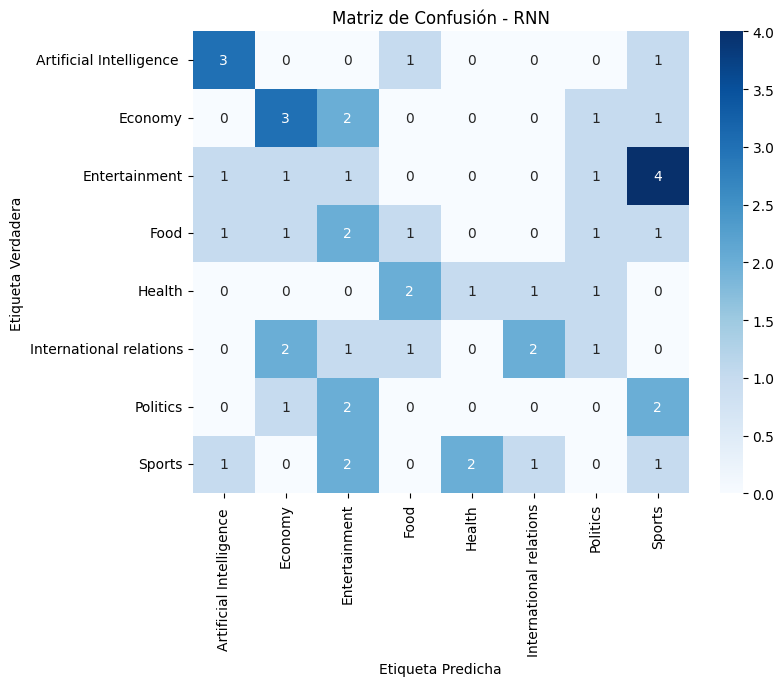


Entrenando Modelo: LSTM
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.1272 - loss: 2.0763 - val_accuracy: 0.1569 - val_loss: 2.0683
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2439 - loss: 2.0520 - val_accuracy: 0.1961 - val_loss: 2.0606
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2326 - loss: 2.0586 - val_accuracy: 0.1765 - val_loss: 2.0534
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2444 - loss: 2.0252 - val_accuracy: 0.1765 - val_loss: 2.0366
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2099 - loss: 1.9930 - val_accuracy: 0.1765 - val_loss: 1.9707
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3287 - loss: 1.8839 - val_accuracy: 0.2353 - val_loss: 1.8988
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2906 - loss: 1.8524 - val_accuracy: 0.1961 - val_loss: 1.8828
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2609 - loss: 1.8518 - val_ac

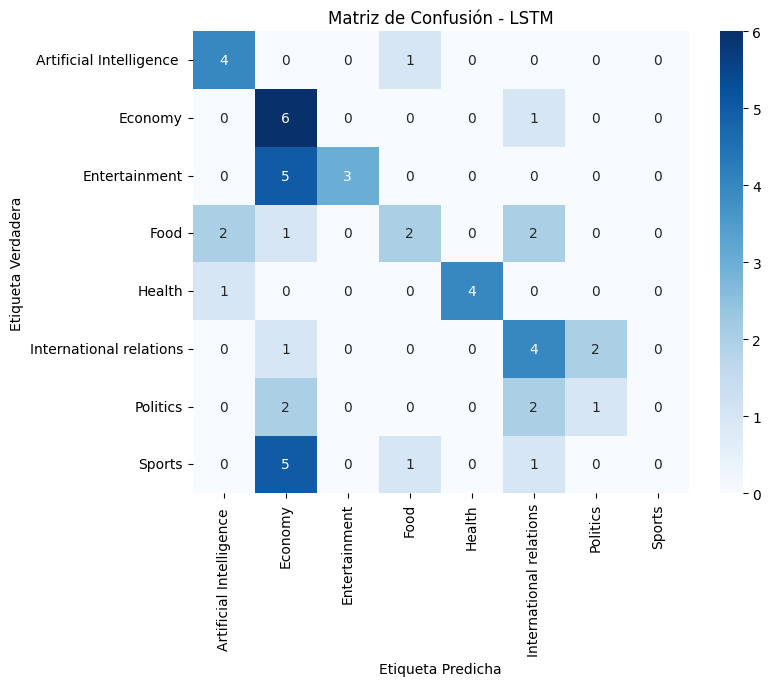


Entrenando Modelo: GRU
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.1198 - loss: 2.0817 - val_accuracy: 0.1176 - val_loss: 2.0759
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1388 - loss: 2.0789 - val_accuracy: 0.1569 - val_loss: 2.0736
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1913 - loss: 2.0749 - val_accuracy: 0.1569 - val_loss: 2.0718
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2469 - loss: 2.0680 - val_accuracy: 0.1765 - val_loss: 2.0710
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2403 - loss: 2.0596 - val_accuracy: 0.1765 - val_loss: 2.0696
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2181 - loss: 2.0599 - val_accuracy: 0.1765 - val_loss: 2.0665
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2467 - loss: 2.0591 - val_accuracy: 0.1765 - val_loss: 2.0652
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2173 - loss: 2.0597 - val_acc


✅ GRU - Accuracy: 0.3333

--- Reporte de Clasificación ---
                          precision    recall  f1-score   support

Artificial Intelligence        0.00      0.00      0.00         5
                 Economy       0.00      0.00      0.00         7
           Entertainment       0.24      1.00      0.38         8
                    Food       0.60      0.43      0.50         7
                  Health       0.56      1.00      0.71         5
 International relations       0.00      0.00      0.00         7
                Politics       0.50      0.20      0.29         5
                  Sports       0.00      0.00      0.00         7

                accuracy                           0.33        51
               macro avg       0.24      0.33      0.24        51
            weighted avg       0.22      0.33      0.23        51



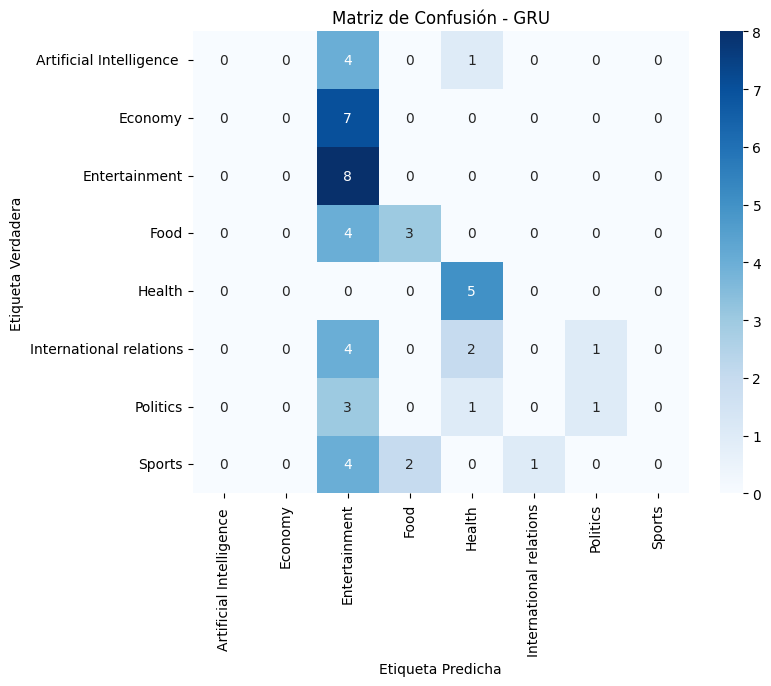


--- Comparación Final de Modelos ---
  Modelo  Accuracy  Precision (Macro)  Recall (Macro)  F1-Score (Macro)
1   LSTM  0.470588           0.513095        0.486161          0.453710
2    GRU  0.333333           0.236356        0.328571          0.235119
0    RNN  0.235294           0.263542        0.240625          0.244314


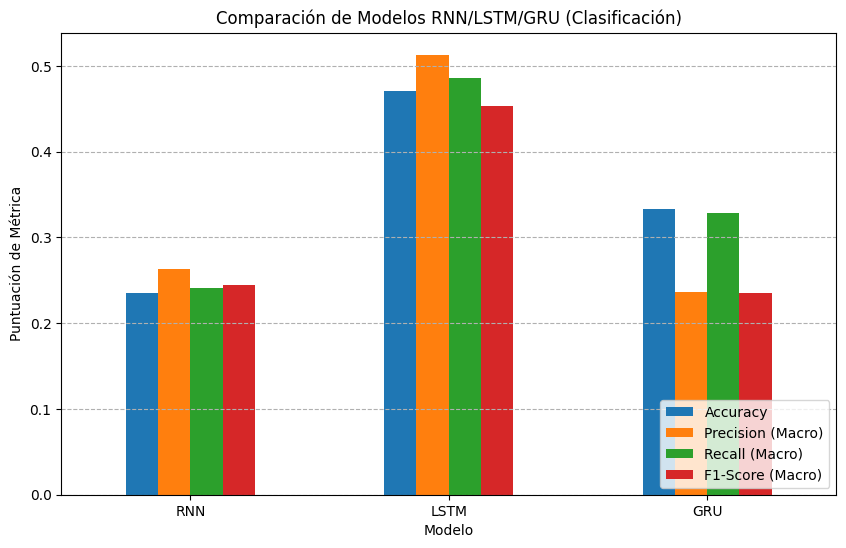

In [ ]:
# ==============================================================================
# 7. Bucle de Entrenamiento
# ==============================================================================

# Se crea una lista par aalmacenar los resultados clave de cada modelo para una
#comparativa final
all_results = []

# Se realiza una iteración sobre el diccionario "models" definido en la etapa anterior
# Cada modelo se entrena, se evalua y se registra.
for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Entrenando Modelo: {model_name}")
    print(f"{'='*60}")

    # 7.1. Definición de Callbacks, se usan para controlar el proceso de entrenamiento
    callbacks = [

        # El model checkpoint realiza un autoguardado de la version en donde el modelo logra su mejor
        # "val_loss" o perdida de validación.
        call.ModelCheckpoint(
            filepath=f'best_model_{model_name}.keras',
            save_best_only=True,
            monitor='val_loss'
        ),

        # El earlystopping detiene el entrenamiento si el "val_loss" no mejora despues de "n+1"
        # pruebas de la variable "patience" o estado de reposo.
        call.EarlyStopping(patience=10, restore_best_weights=True), # Aumentamos patience a 10
    ]

    # 7.2. Entrenamiento de modelos
    # El comando "comand.fit" ejecuta el proceso de aprendizaje usando los datos de entrenamiento.
    # - epochs=100, hara referencia a la cantidad de iteraciones sobre todo el dataset.
    # - Validation_data, son los datos de prueba (X_test, Y_test) usados para medir el rendimiento del modelo.
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100, # Aumentamos epochs a 100 para un dataset pequeño
        verbose=1,
        callbacks=callbacks
    )

    # 7.3. algoritmo de predicción

    # el comando "model.predict" genera el vector de probabildiades para cada muestra
    # del conjunto de prueba.
    y_pred_proba = model.predict(X_test, verbose=0)

    # el comando "np.argmax" con axis=1 convierte el vector de probabilidades a la clase predicha
    # es decir el indice o etiqueta con mayor valor.
    y_pred_classes = np.argmax(y_pred_proba, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)  # Etiquetas verdaderas del conjunto de prueba.


    # 7.4. Evaluación y registro de metricas
    # Generación de reporte de metricas como precision, f1-score, entre otros para analisis de desempeño.
    report = classification_report(
        y_true_classes,
        y_pred_classes,
        target_names=label_encoder.classes_,
        labels=ALL_LABELS_INDICES,  # Garantiza que se muestren las etiquetas obtenidas en la etapa 2.
        output_dict=True,  # Devuelve como diccionario para facilitar el almacenamiento.
        zero_division=0    # Previene errores como por ejemplo, si una clase no fue predicha o no se tuvo en cuenta.
    )

    # El accuracy mide la proporcion de predicciones correctas
    accuracy = accuracy_score(y_true_classes, y_pred_classes)

    # 7.5. Almacenamiento de resultados
    all_results.append({
        'Modelo': model_name,
        'Accuracy': accuracy,
        'Precision (Macro)': report['macro avg']['precision'],
        'Recall (Macro)': report['macro avg']['recall'],
        'F1-Score (Macro)': report['macro avg']['f1-score']
    })

    print(f"\n✅ {model_name} - Accuracy: {accuracy:.4f}")
    print("\n--- Reporte de Clasificación ---")

    # Generación de resultados de forma detallada para cada modelo.
    print(classification_report(
        y_true_classes,
        y_pred_classes,
        target_names=label_encoder.classes_,
        labels=ALL_LABELS_INDICES,
        zero_division=0
    ))

    # 7.6. Matriz de Confusión (Visualización de resutlados)
    # La matriz de confusion es una herramienta visual que permite observar la cantidad
    # de aciertos y errores que logro el modelo respecto a cada etiqueta.
    cm = confusion_matrix(y_true_classes, y_pred_classes, labels=ALL_LABELS_INDICES)
    plt.figure(figsize=(8, 6))

    # El modelo "sns.heatmap" permite visualizar mejor la matriz con colores y anotaciones.
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.show()


# 7.7. Comparación de resultados obtenidos

# Generación del dataframe de resultados totales (RNN vs LSTM vs GRU)
results_df = pd.DataFrame(all_results)
print("\n--- Comparación Final de Modelos ---")

# Demostración de dataframe obtenido por accuracy del modelo ganador.
print(results_df.sort_values(by='Accuracy', ascending=False))

# Visulización de metricas clave para comparativa objetiva de resultados.
results_df.set_index('Modelo').plot(kind='bar', figsize=(10, 6))
plt.title('Comparación de Modelos RNN/LSTM/GRU (Clasificación)')
plt.ylabel('Puntuación de Métrica')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--')
plt.show()

## Etapa 8. Verificación y actualización de modelo con entradas dinamicas.

In [ ]:
# ==============================================================================
# 8. Función de rpedicción con inferencia
# ==============================================================================

def predict_new_text(model_name, new_text, tokenizer, max_len, label_encoder, num_classes):
    """
    Procesa un texto nuevo, usa el modelo para predecir su clase.
    """
    model = models[model_name]

    # 8.1. Preprocesamiento y selección de hiperparametros.
    sequence = tokenizer.texts_to_sequences([new_text])

    # Se emplean las mismas constantes definidas para "max_length".
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # 8.2. Etapa de predicción, el modelo regresa un vector de probabilidad (Softmax).
    prediction_proba = model.predict(padded_sequence, verbose=0)[0]

    # 8.3. Post-procesado para encontrar la etiqueta con mayor probabilidad.
    predicted_index = np.argmax(prediction_proba)
    max_proba = prediction_proba[predicted_index]

    # 8.4. Decodificación para obtener el nombre de la etiqueta.
    predicted_class = label_encoder.inverse_transform([predicted_index])[0]

    return predicted_class, max_proba

# ==============================================================================
# 🎯 EJECUCIÓN INTERACTIVA CON INSERCIÓN EN DF
# ==============================================================================

global df # Necesitamos usar 'global df' para modificar el DataFrame fuera de esta función

best_model_name = 'LSTM' # tomando el modelo que haya tenido mejor resultado

print(f"--- Clasificador de Noticias - Modelo {best_model_name} ---")

# 1. Obtener texto del usuario
new_text = input("Ingresa el texto de la noticia que deseas clasificar: \n")

if new_text.strip():
    # 2. Realizar la predicción
    predicted_category, probability = predict_new_text(
        best_model_name,
        new_text,
        tokenizer,
        MAX_LENGTH,
        label_encoder,
        NUM_CLASSES
    )

    print("\n" + "=" * 50)
    print(f"**ANÁLISIS DE LA NOTICIA**")
    print(f"**Clase Predicha:** {predicted_category}")
    print(f"**Probabilidad:** {probability:.4f}")
    print("=" * 50)

    # 3. CONCATENACIÓN (Inserción) del nuevo dato en el DataFrame 'df'
    # Creamos un nuevo DataFrame temporal con el texto y la categoría predicha
    new_data = pd.DataFrame([{
        TEXT_COLUMN: new_text,
        LABEL_COLUMN: predicted_category
    }])

    # Concatenamos el nuevo DataFrame al DataFrame global 'df'
    df = pd.concat([df, new_data], ignore_index=True)

    # 4. VERIFICACIÓN: Confirmamos la inserción
    print("\n--- De Verificación de Inserción ---")
    print(f"Nuevo tamaño total del DataFrame (df): {len(df)} filas")
    # Mostrar las últimas dos filas (el dato insertado y el anterior)
    print("Últimas filas del DataFrame:")
    print(df.tail(5))

else:
    print("No se ingresó texto.")

# El DataFrame 'df' ahora contiene el nuevo registro.

--- Clasificador de Noticias - Modelo LSTM ---
Ingresa el texto de la noticia que deseas clasificar: 
The food in new york it's very delicious, 'cause the hot dog is really good.

**ANÁLISIS DE LA NOTICIA**
**Clase Predicha:** Economy
**Probabilidad:** 0.4994

--- De Verificación de Inserción ---
Nuevo tamaño total del DataFrame (df): 254 filas
Últimas filas del DataFrame:
                                                  News  \
249  Brazil's presidential election result is being...   
250  Consistently evolving due to trade disputes, t...   
251  Nestle is planning to launch a plant-based Kit...   
252                            Mañana sera un buen dia   
253  The food in new york it's very delicious, 'cau...   

                    Category  
249  International relations  
250  International relations  
251                     Food  
252                  Economy  
253                  Economy  
